## Get data

In [1]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime, timezone
from vnstock3 import Vnstock
import requests

In [2]:
stock_list = []
volume_list = []

for i in glob.glob(r'D:\Quantitative_Research\H-Tech\vnstock_data\*.csv'):
    stocks = pd.read_csv(i).set_index('time')['close'].reset_index()
    volume = pd.read_csv(i).set_index('time')['volume'].reset_index()
    stocks.columns = ['time', i[-7:-3]]
    volume.columns = ['time', i[-7:-3]]
    stock_list.append(stocks.set_index('time'))
    volume_list.append(volume.set_index('time'))

stock_universe_price = pd.concat(stock_list, axis = 1).sort_index()
stock_universe_vol = pd.concat(volume_list, axis = 1).sort_index()

## Data handling

In [3]:
stock_universe_price.rename(columns=lambda x: x[:-1] if x != 'time' else x, inplace=True)
stock_universe_price.index = pd.to_datetime(stock_universe_price.index)
stock_universe_vol.rename(columns=lambda x: x[:-1] if x != 'time' else x, inplace=True)
stock_universe_vol.index = pd.to_datetime(stock_universe_vol.index)

## Get industry

Get all valid industries from VN stock market that have more than 3 companies

In [4]:
stock = Vnstock().stock()
industries = stock.listing.symbols_by_industries()
industry_counts = industries['en_icb_name3'].value_counts()
valid_industries = industry_counts[industry_counts >= 3].index.tolist()

print(f"Valid industries: {valid_industries}")

valid_industries = list(set(valid_industries))

2024-08-08 15:22:27,600 - vnstock3.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2024-08-08 15:22:27,657 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


Valid industries: ['Construction & Materials', 'Real Estate Investment & Services', 'Industrial Transportation', 'Food Producers', 'Gas, Water & Multi-utilities', 'Chemicals', 'Personal Goods', 'Support Services', 'Electricity', 'Travel & Leisure', 'Pharmaceuticals & Biotechnology', 'Industrial Metals & Mining', 'Mining', 'Beverages', 'Financial Services', 'Media', 'Industrial Engineering', 'General Industrials', 'Banks', 'General Retailers', 'Electronic & Electrical Equipment', 'Forestry & Paper', 'Automobiles & Parts', 'Technology Hardware & Equipment', 'Software & Computer Services', 'Nonlife Insurance', 'Health Care Equipment & Services', 'Oil Equipment, Services & Distribution', 'Household Goods & Home Construction', 'Fixed Line Telecommunications', 'Food & Drug Retailers', 'Tobacco', 'Leisure Goods', 'Mobile Telecommunications', 'Oil & Gas Producers']


## Specify universe by Industry

Nonlife Insurance sector (Bảo hiểm phi nhân thọ)

In [47]:
ticker_list = industries[industries['en_icb_name3'] == 'Technology Hardware & Equipment']['symbol'].tolist()
available_tickers = [ticker for ticker in ticker_list if ticker in stock_universe_price.columns]
stock_universe = stock_universe_price[available_tickers]
stock_universe = stock_universe.ffill().fillna(0)
stock_universe.index = pd.to_datetime(stock_universe.index)
stock_universe.index = stock_universe.index.date
stock_universe.index.name = 'date'
stock_universe

,CKV,POT,ELC,VTC,VTE,SMT,KST,ST8,LTC,PMJ,ITD,SAM,ONE,PMT,VEC,VIE
date,,,,,,,,,,,,,,,,
2013-01-02,3.72,6.14,9.73,1.59,0.0,2.33,0.72,2.02,3.85,0.0,1.77,3.14,2.45,19.86,0.0,0.0
2013-01-03,3.49,5.75,9.73,1.59,0.0,2.33,0.72,2.05,3.78,0.0,1.84,3.01,2.42,19.86,0.0,0.0
2013-01-04,3.72,5.75,9.73,1.59,0.0,2.41,0.72,2.05,3.78,0.0,1.87,3.05,2.42,19.86,0.0,0.0
2013-01-07,3.72,5.36,10.14,1.59,0.0,2.41,0.72,2.02,3.78,0.0,1.81,3.01,2.42,19.86,0.0,0.0
2013-01-08,3.77,5.42,10.55,1.59,0.0,2.50,0.72,2.03,4.01,0.0,1.84,3.14,2.42,19.86,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18,15.40,17.60,24.10,10.10,5.5,5.50,14.00,8.32,7.40,20.7,15.35,6.80,6.30,7.90,8.4,6.8
2024-07-19,15.40,17.60,23.50,9.90,5.5,5.50,13.80,8.09,6.80,20.7,14.60,6.72,6.20,7.90,8.4,6.8
2024-07-22,15.12,18.30,23.10,9.30,4.7,5.40,13.80,7.84,6.80,20.7,13.95,6.48,6.00,7.90,8.3,6.8


In [48]:
ticker_list = industries[industries['en_icb_name3'] == 'Technology Hardware & Equipment']['symbol'].tolist()
available_tickers = [ticker for ticker in ticker_list if ticker in stock_universe_vol.columns]
vol = stock_universe_vol[available_tickers]
vol = vol.fillna(0)
vol.index = pd.to_datetime(vol.index)
vol.index = vol.index.date
vol.index.name = 'date'

## Most liquid tickers

Get top 5 most liquid tickers. Already checked for valid companies info, survivorship bias,...

In [49]:
average_volume = vol.mean()
sorted_tickers = average_volume.sort_values(ascending=False)
top_3_tickers = sorted_tickers.head(5).index.tolist()
# top_3_tickers = [ticker for ticker in top_3_tickers if ticker != 'GEE']
stock_universe = stock_universe[top_3_tickers]
stock_universe

,SAM,ELC,ITD,ST8,ONE
date,,,,,
2013-01-02,3.14,9.73,1.77,2.02,2.45
2013-01-03,3.01,9.73,1.84,2.05,2.42
2013-01-04,3.05,9.73,1.87,2.05,2.42
2013-01-07,3.01,10.14,1.81,2.02,2.42
2013-01-08,3.14,10.55,1.84,2.03,2.42
...,...,...,...,...,...
2024-07-18,6.80,24.10,15.35,8.32,6.30
2024-07-19,6.72,23.50,14.60,8.09,6.20
2024-07-22,6.48,23.10,13.95,7.84,6.00


## Train-test split

In [50]:
stock_universe_train = stock_universe.iloc[:-504]
stock_universe_test = stock_universe.iloc[-504:]

## Mean-Reversion with Momentum Overlay

Strategy explanation:
- Calculates day-to-day price change in percentage
- Calculates the price difference over delta_window and also shifts the price data to compare the current price with the price from delta days

Signal generation:
- Part 1: The first part of the signal is based on the idea of mean reversion, where the strategy anticipates that if a price has moved significantly in one direction, it might reverse in the short term. This is captured by the negative sign applied to the price difference.
- Part 2: The second part involves summing up the returns over a longer period (252 days) and ranking these returns. This introduces a momentum factor, where the strategy considers the overall trend of the asset's returns over a year. Assets with higher cumulative returns are given a higher rank, and this rank influences the signal.
- Final signals: The signal from Part 1 is multiplied by the ranked value from Part 2, creating a final alpha signal.

In [22]:
def alpha_signal(df, delta_window=5):
    returns = df.pct_change()
    delay_close = df.shift(delta_window)
    delta_close = df.diff(delta_window)
    alpha_df = pd.DataFrame(0, index=df.index, columns=df.columns)
    
    for col in df.columns:
        part1 = -1 * np.sign((df[col] - delay_close[col]) + delta_close[col])
        part2 = 1 + (returns[col].rolling(window=252).sum())
        rank_part2 = part2.rank(axis=0)
        alpha_df[col] = part1 * (1 + rank_part2)

    return alpha_df

## Order matrix (adjust T + 3)

Order placing logic:

**Buy signal**: If the alpha_signal is greater than the threshold
- If the last order == -1 and the stock is sold less than 3 days, do not place a new order.
- If the last order == 1, continue holding
- If no previous order, place a buy order
- If the last order == -1 and the stock is sold 3 or more days, place a buy order

**Sell signal**:  If the alpha_signal is less than the threshold and the stock holding period is 3 days or more, place a sell order

**Neutral**: 
- If the last order == 1 but the signal is not buy, hold the position (0). 
- If the last order == -1 but the signal is not sell, hold the position (0).

In [36]:
def orders(df, delta_window=6):
    ords = pd.DataFrame(0, index=df.index, columns=df.columns)
    alpha_df = alpha_signal(df, delta_window=delta_window)
    for col in df.columns:
        last_order = 0
        holding_period = 0
        days_since_last_sell = 0
        for i in range(1, len(df)):
            if df[col].iloc[i - 1] > 0 and df[col].iloc[i] > 0:
                bull = alpha_df[col].iloc[i - 1] > 0
                bear = alpha_df[col].iloc[i - 1] < 0
                
                # print(f"Index {i}, Col {col}, Bull {bull}, Bear {bear}, Last Order {last_order}, Holding Period {holding_period}, Days Since Last Sell {days_since_last_sell}")
                
                if bull:
                    if last_order == -1 and days_since_last_sell < 3:
                        ords[col].iloc[i] = 0
                        days_since_last_sell += 1
                    elif last_order == 1:
                        ords[col].iloc[i] = 0
                        holding_period += 1
                    elif last_order == 0:
                        ords[col].iloc[i] = 1
                        last_order = 1
                        days_since_last_sell = 0
                        holding_period += 1
                    else:
                        ords[col].iloc[i] = 1
                        last_order = 1
                        days_since_last_sell = 0
                        holding_period += 1
                elif bear and holding_period >= 3:
                    ords[col].iloc[i] = -1
                    last_order = -1
                    holding_period = 0
                    days_since_last_sell += 1
                elif last_order == 1 and not bull:
                    ords[col].iloc[i] = 0
                    last_order = 1
                    holding_period += 1
                elif last_order == -1 and not bear:
                    ords[col].iloc[i] = 0
                    last_order = -1
                    days_since_last_sell += 1

    return ords

## PnL calculation (equal-weight portfolio)

In [12]:
def calculate_pnl(order_matrix, stock_universe, capital=1000000000):
    num_stocks = len(order_matrix.columns)
    capital_per_stock = capital / num_stocks
    pnl_matrix = pd.DataFrame(np.zeros_like(order_matrix.values), index=order_matrix.index, columns=order_matrix.columns)
    
    for stock in order_matrix.columns:
        buy_prices = []
        holding_days = []

        for i in range(len(order_matrix)):
            order_signal = order_matrix.iloc[i, order_matrix.columns.get_loc(stock)]
            price = stock_universe.iloc[i, stock_universe.columns.get_loc(stock)]
            
            if order_signal == 1:
                # Buy with capital allocation
                buy_price = price
                shares_to_buy = capital_per_stock / buy_price
                buy_prices.append(buy_price)
                holding_days.append(1)
                      
            elif order_signal == -1:
                sell_indices = [idx for idx, days in enumerate(holding_days) if days >= 3]
                if sell_indices:
                    pnl = round(sum((price - buy_prices[idx]) * (capital_per_stock / buy_prices[idx]) for idx in sell_indices), 2)
                    pnl_matrix.iloc[i, pnl_matrix.columns.get_loc(stock)] += pnl
                    buy_prices = [buy_prices[idx] for idx in range(len(buy_prices)) if idx not in sell_indices]
                    holding_days = [days for idx, days in enumerate(holding_days) if idx not in sell_indices]
            else:
                if len(holding_days) >= 1:
                    holding_days = [x + 1 for x in holding_days]
                    
    return pnl_matrix


## Performance matrix

In [13]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    if cum_ret.max() == 0:
        max_dd = np.nan
    else:
        max_dd = (drawdown.max() / cum_ret.max()) * 100
    return sharpe, max_dd

## IS backtest

Sharpe ratio: 1.09
Max drawdown: 12.91%


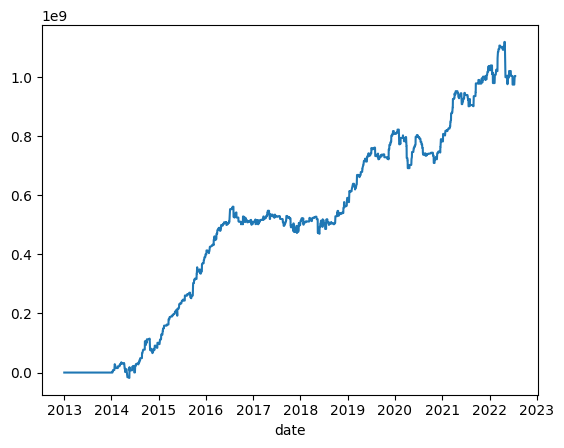

In [51]:
order_matrix = orders(stock_universe_train)
pnl_matrix = calculate_pnl(order_matrix, stock_universe_train)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl) 
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

## Hyperparameters tuning

In [52]:
import optuna

def objective(trial):
    delta_window = trial.suggest_int('delta_window', 2, 20)
    # rolling_window = trial.suggest_int('rolling_window', 2, 30)
    # n = trial.suggest_float('n', 0.1, 1)
    order_matrix = orders(stock_universe_train, delta_window=delta_window)
    pnl_matrix = calculate_pnl(order_matrix, stock_universe_train)
    universe_pnl = pnl_matrix.sum(axis=1)
    sharpe, max_dd = perf_metrics(universe_pnl)
    return sharpe

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f'Best params: {study.best_params}')
print(f'Best Sharpe ratio: {study.best_value:.2f}')

[I 2024-08-08 15:36:43,269] A new study created in memory with name: no-name-e2a834cf-d84a-4a9f-9c03-081bcf9f295c
[I 2024-08-08 15:36:45,040] Trial 0 finished with value: 0.38709276228809214 and parameters: {'delta_window': 15}. Best is trial 0 with value: 0.38709276228809214.
[I 2024-08-08 15:36:46,787] Trial 1 finished with value: 0.5398842198632428 and parameters: {'delta_window': 12}. Best is trial 1 with value: 0.5398842198632428.
[I 2024-08-08 15:36:49,100] Trial 2 finished with value: 0.38709276228809214 and parameters: {'delta_window': 15}. Best is trial 1 with value: 0.5398842198632428.
[I 2024-08-08 15:36:51,143] Trial 3 finished with value: 1.2829121065041562 and parameters: {'delta_window': 3}. Best is trial 3 with value: 1.2829121065041562.
[I 2024-08-08 15:36:53,422] Trial 4 finished with value: 0.5835950202449236 and parameters: {'delta_window': 19}. Best is trial 3 with value: 1.2829121065041562.
[I 2024-08-08 15:36:56,321] Trial 5 finished with value: 0.763756885766398

Best params: {'delta_window': 3}
Best Sharpe ratio: 1.28


Sharpe ratio: 1.28
Max drawdown: 25.51%


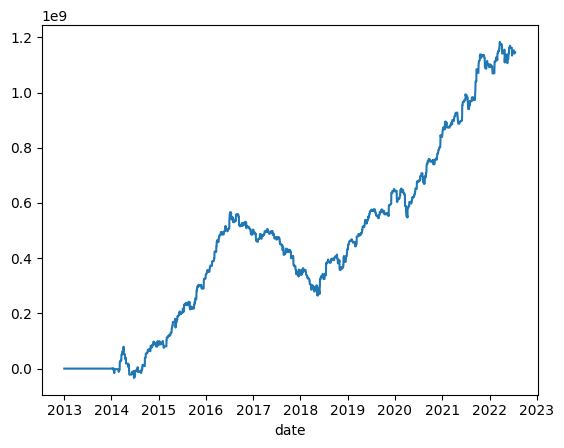

In [53]:
order_matrix = orders(stock_universe_train, delta_window=study.best_params["delta_window"])
pnl_matrix = calculate_pnl(order_matrix, stock_universe_train)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl) 
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

## OS backtest

Sharpe ratio: 1.26
Max drawdown: 27.05%


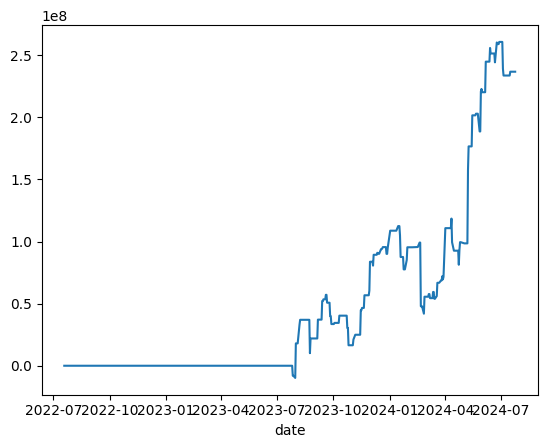

In [54]:
order_matrix = orders(stock_universe_test, study.best_params["delta_window"])
pnl_matrix = calculate_pnl(order_matrix, stock_universe_test)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl) 
print(f"Sharpe ratio: {sharpe:.2f}") 
print(f"Max drawdown: {max_dd:.2f}%")